C:\Users\Niloy\AppData\Local\Temp\ipykernel_18672\2224526927.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.replace({-1: None, -2: None}, inplace=True)
C:\Users\Niloy\AppData\Local\Temp\ipykernel_18672\2224526927.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.apply(lambda col: col.fillna(col.mode()[0]))


Train Metrics (Accuracy, Precision, Recall, F1): (0.5849387040280211, 0.5711046920828626, 0.5849387040280211, 0.5491773926005351)
Test Metrics (Accuracy, Precision, Recall, F1): (0.45454545454545453, 0.4259093643709029, 0.45454545454545453, 0.4330805206069477)

Classification Report for Train Set:
                       precision    recall  f1-score   support

      1 (0-1 doctors)       0.49      0.25      0.33       103
      2 (2-3 doctors)       0.60      0.85      0.70       298
3 (4 or more doctors)       0.57      0.32      0.41       170

             accuracy                           0.58       571
            macro avg       0.55      0.47      0.48       571
         weighted avg       0.57      0.58      0.55       571


Classification Report for Test Set:
                       precision    recall  f1-score   support

      1 (0-1 doctors)       0.27      0.14      0.19        28
      2 (2-3 doctors)       0.53      0.65      0.58        74
3 (4 or more doctors)       0.

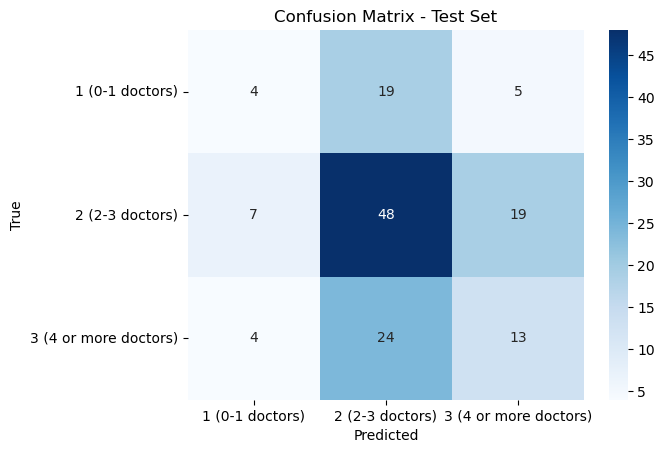

In [3]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt


dataset = pd.read_csv('NPHA-doctor-visits.csv')

# Select relevant features and target
X = dataset[['Dental Health', 'Mental Health', 'Physical Health', 'Race', 'Employment']]
y = dataset['Number of Doctors Visited']

# Handle missing values (-1 for "Refused", -2 for "Not asked")
X.replace({-1: None, -2: None}, inplace=True)

# Fill missing values with the mode (most frequent value)
X = X.apply(lambda col: col.fillna(col.mode()[0]))

# Convert categorical variables to numerical using LabelEncoder
label_encoders = {}
for column in ['Dental Health', 'Mental Health', 'Physical Health', 'Race', 'Employment']:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le  # Store the encoder for future use

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Decision Tree Classifier with pruning
dt_classifier = DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=10, min_samples_leaf=4)

# Train the model
dt_classifier.fit(X_train, y_train)

# Make predictions for train and test sets
y_pred_train = dt_classifier.predict(X_train)
y_pred_test = dt_classifier.predict(X_test)

# Calculate accuracy, precision, recall, f1 score for train and test sets
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1

train_metrics = calculate_metrics(y_train, y_pred_train)
test_metrics = calculate_metrics(y_test, y_pred_test)

# Confusion Matrix
cm_test = confusion_matrix(y_test, y_pred_test)
cm_train = confusion_matrix(y_train, y_pred_train)

# Classification Report for test and train sets
class_report_test = classification_report(y_test, y_pred_test, target_names=['1 (0-1 doctors)', '2 (2-3 doctors)', '3 (4 or more doctors)'])
class_report_train = classification_report(y_train, y_pred_train, target_names=['1 (0-1 doctors)', '2 (2-3 doctors)', '3 (4 or more doctors)'])

# Calculate True Positive Rate (TPR) and False Positive Rate (FPR) for each class
def calculate_tpr_fpr(cm):
    tpr_fpr = {}
    for i in range(cm.shape[0]):  # Loop through each class
        TP = cm[i][i]  # True positives are the diagonal elements
        FN = sum(cm[i]) - TP  # False negatives are the sum of the row minus the TP
        FP = sum(cm[:, i]) - TP  # False positives are the sum of the column minus the TP
        TN = sum(sum(cm)) - (TP + FN + FP)  # True negatives are the total minus TP, FN, FP
        
        TPR = TP / (TP + FN) if (TP + FN) > 0 else 0  # True Positive Rate
        FPR = FP / (FP + TN) if (FP + TN) > 0 else 0  # False Positive Rate
        
        tpr_fpr[i] = {'TPR': TPR, 'FPR': FPR}
    return tpr_fpr

# Calculate TPR and FPR for the confusion matrices
tpr_fpr_train = calculate_tpr_fpr(cm_train)
tpr_fpr_test = calculate_tpr_fpr(cm_test)

# Print results
print(f"Train Metrics (Accuracy, Precision, Recall, F1): {train_metrics}")
print(f"Test Metrics (Accuracy, Precision, Recall, F1): {test_metrics}")
print(f"\nClassification Report for Train Set:\n{class_report_train}")
print(f"\nClassification Report for Test Set:\n{class_report_test}")

# Print TPR and FPR for the train set
print("\nTrue Positive Rate (TPR) and False Positive Rate (FPR) for Train Set:")
for i, metrics in tpr_fpr_train.items():
    print(f"Class {i+1}: TPR = {metrics['TPR']:.2f}, FPR = {metrics['FPR']:.2f}")

# Print TPR and FPR for the test set
print("\nTrue Positive Rate (TPR) and False Positive Rate (FPR) for Test Set:")
for i, metrics in tpr_fpr_test.items():
    print(f"Class {i+1}: TPR = {metrics['TPR']:.2f}, FPR = {metrics['FPR']:.2f}")

# Visualize the confusion matrix for the test set
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['1 (0-1 doctors)', '2 (2-3 doctors)', '3 (4 or more doctors)'], yticklabels=['1 (0-1 doctors)', '2 (2-3 doctors)', '3 (4 or more doctors)'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.show()
